## Using Haiku as a sub-agent
In this recipe, we'll demonstrate how to analyze Apple's 2023 financial earnings reports using Claude 3 Haiku sub-agent models to extract relevant information from earnings release PDFs. We'll then use Claude 3 Opus to generate a response to our question and create a graph using matplotlib to accompany its response.

### Step 1: Set up the environment
First, let's install the required libraries and set up the Anthropic API client.

In [ ]:
%pip install anthropic IPython PyMuPDF matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.1/869.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Import the required libraries
import fitz
import base64
from PIL import Image
import io
from concurrent.futures import ThreadPoolExecutor
from anthropic import Anthropic
import requests
import os


In [ ]:
from google.colab import userdata
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

In [ ]:
# Set up the Anthropic API client
client = Anthropic()
MODEL_NAME = "claude-3-haiku-20240229"

### Step 2: Gather our documents and ask a question
For this example, we will be using all Apple's financial statements from the 2023 financial year and asking about the net sales over the year.

In [ ]:
# List of Apple's earnings release PDF URLs
pdf_urls = [
    "https://www.apple.com/newsroom/pdfs/fy2023-q4/FY23_Q4_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/fy2023-q3/FY23_Q3_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q2_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q1_Consolidated_Financial_Statements.pdf"
]

### Step 3: Download and convert PDFs to images

Next, we'll define functions to download the earnings release PDFs and convert them to base64-encoded PNG images. We have to do this because these PDFs are full of tables that are hard to parse with traditional PDF parsers. It's easier if we just convert them to images and pass the images to Haiku.

The download_pdf function downloads a PDF file from a given URL and saves it to the specified folder. The pdf_to_base64_pngs function converts a PDF to a list of base64-encoded PNG images.

In [ ]:
import urllib.request

def download_pdf(url, folder_path):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Extracting filename from URL
    file_name = url.split('/')[-1]

    # Full path where you want to save the PDF
    file_path = os.path.join(folder_path, file_name)

    # Download the PDF
    try:
        urllib.request.urlretrieve(url, file_path)
        print(f'File downloaded successfully and saved to {file_path}')
    except Exception as e:
        print(f'An error occurred: {e}')

In [ ]:
# Define the function to convert a PDF to a list of base64-encoded PNG images
def pdf_to_base64_pngs(pdf_path, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)

    base64_encoded_pngs = []

    # Iterate through each page of the PDF
    for page_num in range(doc.page_count):
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Convert the pixmap to a PIL Image
        image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)

        # Convert the PIL Image to base64-encoded PNG
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

    # Close the PDF document
    doc.close()

    return base64_encoded_pngs


In [ ]:
# Folder to save the downloaded PDFs
folder = "../images/using_sub_agents"

# # Download the PDFs concurrently
# with ThreadPoolExecutor() as executor:
#     pdf_paths = list(executor.map(download_pdf, pdf_urls, [folder] * len(pdf_urls)))

pdf_paths = os.listdir(folder)
pdf_paths = [f"{folder}/{file}" for file in pdf_paths]

# # Remove any None values (failed downloads) from pdf_paths
pdf_paths = [path for path in pdf_paths if path is not None]

In [ ]:
for file in pdf_urls:

  download_pdf(file, folder)

File downloaded successfully and saved to ../images/using_sub_agents/FY23_Q4_Consolidated_Financial_Statements.pdf
File downloaded successfully and saved to ../images/using_sub_agents/FY23_Q3_Consolidated_Financial_Statements.pdf
File downloaded successfully and saved to ../images/using_sub_agents/FY23_Q2_Consolidated_Financial_Statements.pdf
File downloaded successfully and saved to ../images/using_sub_agents/FY23_Q1_Consolidated_Financial_Statements.pdf


### Step 4: Generate a specific prompt for Haiku using Opus
Let's use Opus as an orchestrator and have it write a specific prompt for each Haiku sub-agent based on the user provided question.

In [ ]:
# User's question
QUESTION = "How did Apple's net sales change quarter to quarter in the 2023 financial year and what were the key contributors to the changes?"

In [ ]:
def generate_haiku_prompt(question):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Based on the following question, please generate a specific prompt for an LLM sub-agent to extract relevant information from an earning's report PDF. Each sub-agent only has access to a single quarter's earnings report. Output only the prompt and nothing else.\n\nQuestion: {question}"}
            ]
        }
    ]

    response = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=2048,
        messages=messages
    )

    return response.content[0].text

haiku_prompt = generate_haiku_prompt(QUESTION)
print(haiku_prompt)

Extract the following information from Apple's earnings report for the quarter you have access to:

1. The total net sales for the quarter in dollars.
2. The percent change in total net sales compared to the same quarter in the previous year. 
3. A breakdown of net sales by product category for the quarter in dollars.
4. For each product category, note whether net sales increased or decreased compared to the same quarter in the previous year and by what percentage.
5. Note any explanations provided in the report for significant changes in net sales overall or for specific product categories.

Provide the information in a clear, structured format.


### Step 5: Extract information from PDFs
Now, let's define our question and extract information from the PDFs using sub-agent Haiku models. We format the information from each model into a neatly defined set of XML tags.

In [ ]:
def extract_info(pdf_path, haiku_prompt):

    base64_encoded_pngs = pdf_to_base64_pngs(pdf_path)

    messages = [
        {
            "role": "user",
            "content": [
                *[{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": base64_encoded_png}} for base64_encoded_png in base64_encoded_pngs],
                {"type": "text", "text": haiku_prompt}
            ]
        }
    ]

    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2048,
        messages=messages
    )

    return response.content[0].text, pdf_path

In [ ]:
def process_pdf(pdf_path):
    return extract_info(pdf_path, QUESTION)

# Process the PDFs concurrently with Haiku sub-agent models
with ThreadPoolExecutor() as executor:
    extracted_info_list = list(executor.map(process_pdf, pdf_paths))

extracted_info = ""
# Display the extracted information from each model call
for info in extracted_info_list:
    extracted_info += "<info quarter=\"" + info[1].split("/")[-1].split("_")[1] + "\">" + info[0] + "</info>\n"
print(extracted_info)

<info quarter="Q3">Based on the condensed consolidated statements of operations, Apple's net sales increased from $81,797 million in the three months ended July 1, 2023 to $82,959 million in the nine months ended June 25, 2022, an increase of approximately $1,162 million.

The key contributors to the increase in net sales were:

1. Products segment sales increased from $60,584 million in the three months ended July 1, 2023 to $63,355 million in the nine months ended June 25, 2022, an increase of $2,771 million.

2. Services segment sales increased from $21,213 million in the three months ended July 1, 2023 to $19,604 million in the nine months ended June 25, 2022, an increase of $1,609 million.

So the growth in both product and services revenue contributed to the overall increase in Apple's net sales quarter-over-quarter.</info>
<info quarter="Q2">According to the condensed consolidated statements of operations, Apple's net sales increased from $94,836 million in the three months ende

### Step 6: Pass the information to Opus to generate a response
Now that we have fetched the information from each PDF using the sub-agents, let's call Opus to actually answer the question and write code to create a graph to accompany the answer.



In [ ]:
# Prepare the messages for the powerful model
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": f"""Based on the following extracted information from Apple's earnings releases, please provide a response to the question: {QUESTION}

             Also, please generate Python code using the matplotlib library to accompany your response. Enclose the code within <code> tags.

             Extracted Information:\n{extracted_info}"""}
        ]
    }
]

# Generate the matplotlib code using the powerful model
response = client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=4096,
    messages=messages
)

generated_response = response.content[0].text
print("Generated Response:")
print(generated_response)

Generated Response:
Based on the extracted information from Apple's earnings releases, Apple's net sales showed the following changes quarter-over-quarter in the 2023 financial year:

1. In Q1 (three months ended December 31, 2022), net sales increased compared to the same quarter in the previous year, driven by higher product sales and services revenue.

2. In Q2 (three months ended April 1, 2023), net sales significantly increased compared to the same period in the previous year, with substantial growth in both product and services sales.

3. In Q3 (three months ended July 1, 2023), net sales increased compared to the same period in the previous year, with growth in both product and services revenue contributing to the overall increase.

4. In Q4 (three months ended September 30, 2023), net sales decreased slightly compared to the same quarter in the previous year. This decrease was primarily driven by a decline in product sales, partially offset by an increase in services sales.

Th

### Step 7: Extract response and execute Matplotlib code
Finally, let's extract the matplotlib code from the generated response and execute it to visualize the revenue growth trend.

We define the extract_code_and_response function to extract the matplotlib code and non-code response from the generated response. We print the non-code response and execute the matplotlib code if it is found.

Note that it is not good practice to use exec on model-written code outside of a sandbox but for the purposes of this demo we are doing it :)

Based on the extracted information from Apple's earnings releases, Apple's net sales showed the following changes quarter-over-quarter in the 2023 financial year:

1. In Q1 (three months ended December 31, 2022), net sales increased compared to the same quarter in the previous year, driven by higher product sales and services revenue.

2. In Q2 (three months ended April 1, 2023), net sales significantly increased compared to the same period in the previous year, with substantial growth in both product and services sales.

3. In Q3 (three months ended July 1, 2023), net sales increased compared to the same period in the previous year, with growth in both product and services revenue contributing to the overall increase.

4. In Q4 (three months ended September 30, 2023), net sales decreased slightly compared to the same quarter in the previous year. This decrease was primarily driven by a decline in product sales, partially offset by an increase in services sales.

The key contributors t

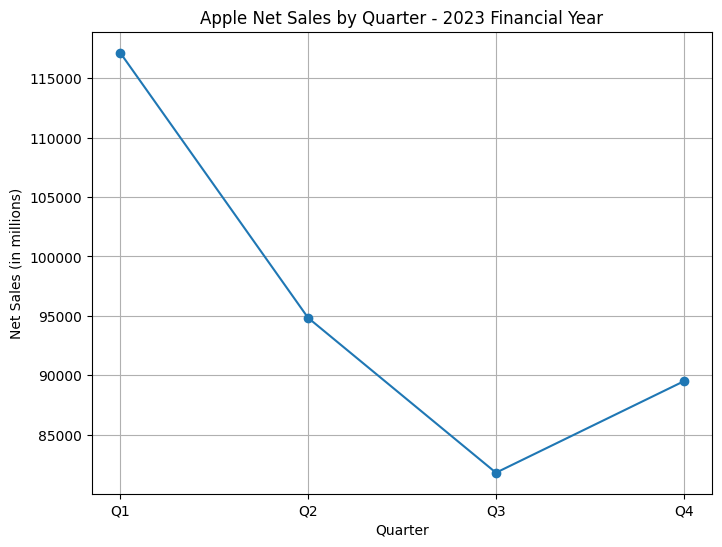

In [ ]:
# Extract the matplotlib code from the response
# Function to extract the code and non-code parts from the response
def extract_code_and_response(response):
    start_tag = "<code>"
    end_tag = "</code>"
    start_index = response.find(start_tag)
    end_index = response.find(end_tag)
    if start_index != -1 and end_index != -1:
        code = response[start_index + len(start_tag):end_index].strip()
        non_code_response = response[:start_index].strip()
        return code, non_code_response
    else:
        return None, response.strip()

matplotlib_code, non_code_response = extract_code_and_response(generated_response)

print(non_code_response)
if matplotlib_code:

    # Execute the extracted matplotlib code
    exec(matplotlib_code)
else:
    print("No matplotlib code found in the response.")